In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from calflops import calculate_flops
work_path = "/home/re6125015/DeepL/images"
os.chdir(work_path)
os.getpid()

/opt/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


243941

In [2]:
def load_npz_data(file_path):
    loaded = np.load(file_path)
    X = loaded['array1']  # Adjust 'array1' if your image data key is different
    y = loaded['array2']  # Adjust 'array2' if your label data key is different
    return X, y

X_train, y_train = load_npz_data('train.npz')
X_val, y_val = load_npz_data('val.npz')
X_test, y_test = load_npz_data('test.npz')

In [3]:
class NPZDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)  # Ensure label is torch.long

In [4]:
res = 84
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((res, res)),  # ResNet typically uses 224x224 input images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = NPZDataset(X_train, y_train, transform=transform)
val_dataset = NPZDataset(X_val, y_val, transform=transform)
test_dataset = NPZDataset(X_test, y_test, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [5]:
class DynamicSelectiveConvLayer(nn.Module):
    def __init__(self, max_channels, out_channels, kernel_size, stride=1, padding=1, bias=False):
        super(DynamicSelectiveConvLayer, self).__init__()
        self.max_channels = max_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.bias_param = bias
        
        # Instead of generating weights for max_channels, generate for each possible subset size
        self.weight_gens = nn.ModuleDict({
            f"{i}": nn.Linear(i, out_channels * i * kernel_size * kernel_size)
            for i in range(1, max_channels + 1)
        })
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channels))
        else:
            self.register_parameter('bias', None)

    def forward(self, x, selected_channels):
        # Generate channel mask based on selected_channels
        channel_mask = torch.zeros(self.max_channels, dtype=torch.bool)
        channel_indices = torch.tensor(selected_channels, dtype=torch.long)
        channel_mask[channel_indices] = True
        
        # Apply mask to filter out unwanted channels
        x_selected = x[:, channel_mask, :, :]
        
        # Generate dynamic weights according to the number of selected channels
        num_selected_channels = x_selected.size(1)
        avg_pool = F.adaptive_avg_pool2d(x_selected, 1).view(x_selected.size(0), -1)
        dynamic_weights = self.weight_gens[f"{num_selected_channels}"](avg_pool)
        dynamic_weights = dynamic_weights.view(-1, self.out_channels, num_selected_channels, self.kernel_size, self.kernel_size)

        # Perform convolution for each batch independently
        outputs = [F.conv2d(x_selected[i].unsqueeze(0), dynamic_weights[i], self.bias, self.stride, self.padding)
                   for i in range(x_selected.size(0))]
        return torch.cat(outputs, dim=0)

In [6]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [7]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = DynamicSelectiveConvLayer(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x, selected_channels = [0, 1, 2]):
        x = self.conv1(x, selected_channels)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=50).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# # Define a StepLR scheduler
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [9]:
batch_size = 64
input_shape = (batch_size, 3, 84, 84)
flops, macs, params = calculate_flops(model=model, 
                                      input_shape=input_shape,
                                      output_as_string=True,
                                      output_precision=4)
print("FLOPs:%s   MACs:%s   Params:%s \n" %(flops, macs, params))


------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  11.2 M  
fwd MACs:                                                               67.7947 GMACs
fwd FLOPs:                                                              135.889 GFLOPS
fwd+bwd MACs:                                                           203.384 GMACs
fwd+bwd FLOPs:                                                          407.667 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each mo

In [10]:
num_epochs = 50
early_stopping_counter = 0
best_val_loss = float('inf')
selected_channels = [0, 1, 2]  # RGB for training, can be changed as needed

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass with dynamic channel selection
        outputs = model(inputs, selected_channels)
        loss = criterion(outputs, labels)
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize the model

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100

    # Validation
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs, selected_channels)  # Ensure dynamic channel selection is used
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= total
    val_acc = correct / total * 100

    print(f'Epoch {epoch + 1}: Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.2f}% Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}%')

    # Step the scheduler after each epoch (if using scheduler)
    # scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'part1/best_model_v2_{res}.pth')  # Save the best model
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter > 2:  # stops if no improvement after 3 epochs
        print("Early stopping triggered.")
        break

/home/re6125015/.local/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1: Train Loss: 3.2972 Train Acc: 13.35% Val Loss: 2.9721 Val Acc: 18.22%
Epoch 2: Train Loss: 2.7838 Train Acc: 22.97% Val Loss: 2.6575 Val Acc: 25.78%
Epoch 3: Train Loss: 2.4946 Train Acc: 29.63% Val Loss: 2.5702 Val Acc: 28.89%
Epoch 4: Train Loss: 2.2370 Train Acc: 35.41% Val Loss: 2.2534 Val Acc: 34.44%
Epoch 5: Train Loss: 1.9958 Train Acc: 41.41% Val Loss: 2.0297 Val Acc: 40.22%
Epoch 6: Train Loss: 1.7860 Train Acc: 46.78% Val Loss: 1.9792 Val Acc: 41.11%
Epoch 7: Train Loss: 1.6018 Train Acc: 51.57% Val Loss: 1.8119 Val Acc: 46.22%
Epoch 8: Train Loss: 1.4335 Train Acc: 56.08% Val Loss: 1.8421 Val Acc: 46.89%
Epoch 9: Train Loss: 1.2820 Train Acc: 59.91% Val Loss: 1.7130 Val Acc: 48.67%
Epoch 10: Train Loss: 1.1247 Train Acc: 64.26% Val Loss: 1.7929 Val Acc: 48.67%
Epoch 11: Train Loss: 0.9892 Train Acc: 68.00% Val Loss: 1.7310 Val Acc: 46.67%
Epoch 12: Train Loss: 0.8586 Train Acc: 71.76% Val Loss: 1.9566 Val Acc: 50.00%
Early stopping triggered.


In [11]:
print(best_val_loss)

1.7130134934849208


In [12]:
model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=50)
model.load_state_dict(torch.load(f'part1/best_model_v2_{res}.pth'))
model.eval()  # Set the model to evaluation mode
model.to(device)  # Move model to the appropriate device (CPU or GPU)

ResNet(
  (conv1): DynamicSelectiveConvLayer(
    (weight_gens): ModuleDict(
      (1): Linear(in_features=1, out_features=576, bias=True)
      (2): Linear(in_features=2, out_features=1152, bias=True)
      (3): Linear(in_features=3, out_features=1728, bias=True)
    )
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=

In [13]:
# Function to make predictions and optionally evaluate the model with selected channels
def predict(model, data_loader, selected_channels):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    all_predictions = []
    all_labels = []  # Optional, only if labels are available in the test set

    with torch.no_grad():  # No need to track gradients for predictions
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            # Update the model call to include selected_channels
            outputs = model(inputs, selected_channels)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())  # Optional

    return all_predictions, all_labels

# Example of using the updated predict function
selected_channels = [0, 1, 2]  # For example, use only Red and Green channels
predictions, labels = predict(model, test_loader, selected_channels)

In [14]:
if labels:
    accuracy = accuracy_score(labels, predictions) * 100
    print(f"Accuracy on test data: {accuracy:.2f}%")

Accuracy on test data: 54.00%


In [15]:
# Example of saving predictions to a CSV file
result_df = pd.DataFrame({'PredictedLabel': predictions})
result_df.to_csv(f'part1/predict_rgb_v2_{res}.csv', index=False)

In [18]:
selected_channels = [0, 1]  # For example, use only Red and Green channels
predictions, labels = predict(model, test_loader, selected_channels)
if labels:
    accuracy = accuracy_score(labels, predictions) * 100
    print(f"Accuracy on test data (RG): {accuracy:.2f}%")

Accuracy on test data: 1.78%


In [19]:
selected_channels = [0, 2]  # For example, use only Red and Green channels
predictions, labels = predict(model, test_loader, selected_channels)
if labels:
    accuracy = accuracy_score(labels, predictions) * 100
    print(f"Accuracy on test data (RB): {accuracy:.2f}%")

Accuracy on test data (RB): 2.00%


In [20]:
selected_channels = [1, 2]  # For example, use only Red and Green channels
predictions, labels = predict(model, test_loader, selected_channels)
if labels:
    accuracy = accuracy_score(labels, predictions) * 100
    print(f"Accuracy on test data (GB): {accuracy:.2f}%")

Accuracy on test data (GB): 2.67%


In [21]:
selected_channels = [0]  # For example, use only Red and Green channels
predictions, labels = predict(model, test_loader, selected_channels)
if labels:
    accuracy = accuracy_score(labels, predictions) * 100
    print(f"Accuracy on test data (R): {accuracy:.2f}%")

Accuracy on test data (R): 2.00%


In [22]:
selected_channels = [1]  # For example, use only Red and Green channels
predictions, labels = predict(model, test_loader, selected_channels)
if labels:
    accuracy = accuracy_score(labels, predictions) * 100
    print(f"Accuracy on test data (G): {accuracy:.2f}%")

Accuracy on test data (G): 3.11%


In [23]:
selected_channels = [2]  # For example, use only Red and Green channels
predictions, labels = predict(model, test_loader, selected_channels)
if labels:
    accuracy = accuracy_score(labels, predictions) * 100
    print(f"Accuracy on test data (B): {accuracy:.2f}%")

Accuracy on test data (B): 2.89%


In [16]:
# Print classification report
print("Classification Report:")
print(classification_report(labels, predictions))

# Print confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(labels, predictions)
print(cm)

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.44      0.42         9
           1       0.30      0.33      0.32         9
           2       0.56      0.56      0.56         9
           3       0.78      0.78      0.78         9
           4       0.75      0.67      0.71         9
           5       0.67      0.89      0.76         9
           6       0.50      0.67      0.57         9
           7       0.75      0.33      0.46         9
           8       1.00      0.33      0.50         9
           9       0.40      0.22      0.29         9
          10       0.60      0.67      0.63         9
          11       0.00      0.00      0.00         9
          12       1.00      0.44      0.62         9
          13       0.27      0.44      0.33         9
          14       0.29      0.22      0.25         9
          15       0.38      0.67      0.48         9
          16       0.11      0.11      0.11         9
    

/home/re6125015/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/re6125015/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/re6125015/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


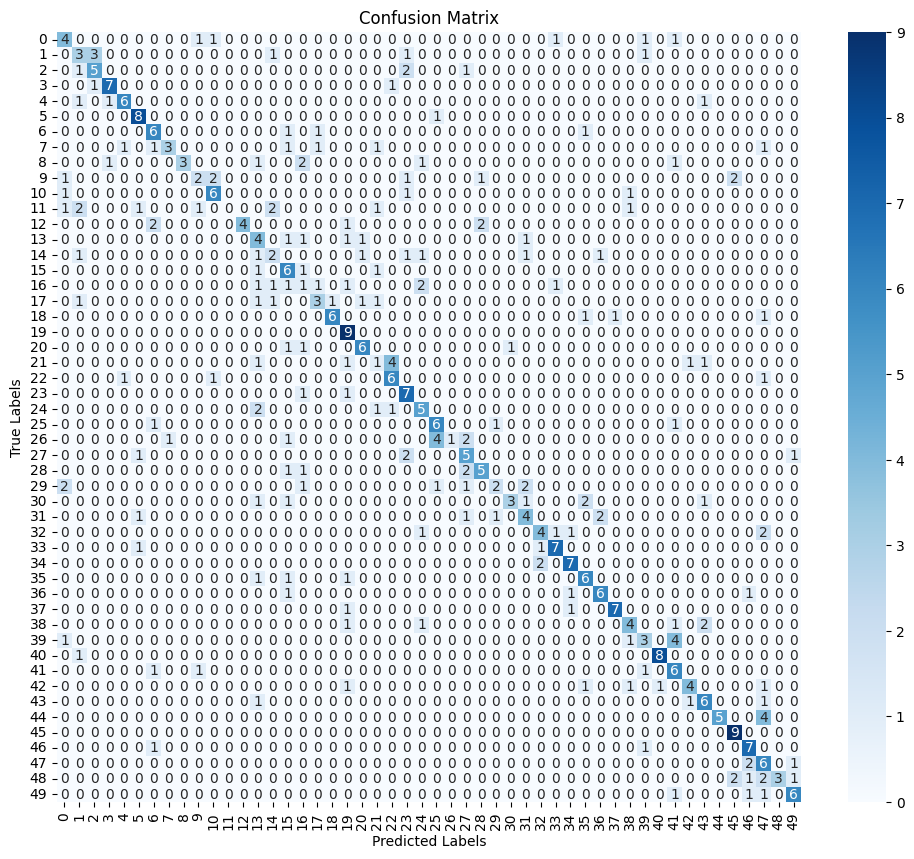

In [17]:
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()